Goal: assess performance of tensor decompsition, and in particular the "how" paramater, in the presence of changing/missing cell types across contexts

In [1]:
suppressPackageStartupMessages({
    library(splatter)
    
    library(scater)
    library(scran)
    library(bluster)
    
    library(stringr)
    library(ggpubr, quietly = T)
    
    library(plyr, quietly = T)
    library(reshape2, quietly = T)
    
    library(StabEco, quietly = T)
    library(igraph, quietly = T)
    
    library(liana, quietly = T)
    library(tibble, quietly = T)
    c2c <- reticulate::import(module = "cell2cell", as="c2c")
    
    library(ggplot2, quietly = T)

})

seed <- 888
set.seed(seed)
n.cores <- 15

env.name<-'ccc_protocols'
data.path<-'/data3/hratch/ccc_protocols/'

# Functions

In [2]:
# generate a scale-free, undirected, bipartite PPI network
# emulate from c2c_sim (https://github.com/hmbaghdassarian/c2c_sim) based on Simulate.LR_network method
# with same parameters as in first tensor-cell2cell paper (https://github.com/hmbaghdassarian/tc2c_analyses_1/tree/master/notebooks/time_simulation)
generate.lr.ppi<-function(lr.genes, seed = 888){
    alpha<-2
    degrees<-3
    edges<-NULL

    set.seed(seed)
    B = StabEco::BiGraph$new(n1=length(lr.genes)/2, beta=alpha, k=degrees, m=edges, 
                             type = 'bipartite_sf', directed = T, is_adj = F)# simulate
    G = B$get_graph()  # adjacency matrix

    if (!isSymmetric(G)){stop('Not a bipartite network')}

    node_groups = list(ligand = 1:B$n1, receptor = (B$n1+1):(B$n1+B$n2))

    G[lower.tri(G, diag = TRUE)] <- NA # symmetric
    G<-reshape2::melt(G) #adjacency list
    G = G[!is.na(G$value), ] # remove symmetric bidirectionality
    G = G[G$value != 0, ] # remove disconnected nodes

    colnames(G)<-c('Ligand', 'Receptor', 'Interaction.Strength')
    rownames(G)<-NULL
    G<-G[, c('Ligand', 'Receptor')]

    # map to simulated dataset gene names
    # the nodes must be a subset of those that are interacting
    if ((length(setdiff(G$Ligand, node_groups$ligand)) > 0) | (length(setdiff(G$Receptor, node_groups$receptor)) > 0)){
        stop('Something went wrong in ligand & receptor assignment')
    }
    ligand.map<-setNames(lr.genes[1:B$n1], node_groups$ligand)
    receptor.map<-setNames(lr.genes[(B$n1+1):(B$n1+B$n2)], node_groups$receptor)
    lr.map<-c(ligand.map, receptor.map)
    G[['Ligand']]<-ligand.map[as.character(G$Ligand)]
    G[['Receptor']]<-receptor.map[as.character(G$Receptor)]

    if (length(intersect(G$Ligand, G$Receptor)) != 0){stop('Not a bipartite network')}
    
    # format for LIANA
    colnames(G)<-c('source_genesymbol', 'target_genesymbol')
    G<-as_tibble(G)
    
    return(G)
    
}

qc.data<-function(sce){
    # taken from PMID: 34949812
    
    # QC of cells
    sce <- scater::addPerCellQC(sce) # typical QC as in batch correction paper
    discard <- lapply(unique(colData(sce)$Batch), function(batch) {
        in_batch <- colData(sce)$Batch == batch
        scater::quickPerCellQC(colData(sce)[in_batch, ], nmads = 2)$discard
    })
    discard <- unlist(discard)
    colData(sce)$Discard <- discard
    sce <- sce[, !discard]

    # QC of genes
    sce <- scater::addPerFeatureQC(sce)
    is_exprs <- rowData(sce)$detected >= 0.01
    sce <- sce[is_exprs, ]
    
    return(sce)
}

random.omit<-function(sim, md.group.label, frac, seed = 888){
    md.group<-unique(sim[[md.group.label]])
    n.md.group<-length(md.group)
    set.seed(seed)
    omit.md.group = sort(as.character(sample(md.group, size = frac*n.md.group, replace = FALSE)))
    
    return(omit.md.group)
}

split.by.context<-function(sim){
    sim.bc<-list()
    contexts<-unique(sim[['Batch']])
    for (context in contexts){
        bc<-rownames(colData(sim)[(colData(sim)$Batch == context),])
        sim.bc[[context]]<-sim[, bc]
    }
    return(sim.bc)
}

score.communication.sce<-function(sce, lr.ppi, seed = 888){
    communication.scores<-liana_wrap(sce = sce, 
                                       method = c('natmi', 'sca'), 
                                       idents_col = 'Group', 
                                       assay.type = 'logcounts',
                                       expr_prop = 0.1, # liana default
                                       seed = seed,
                                       parallelize = T, 
                                       workers = n.cores, 
                                       permutation.params = list(nperms = 1), # since we don't use p-values
                                       resource = 'custom',
                                       external_resource = lr.ppi
                                      )

    # filter for columns of interest and format
    communication.scores[['natmi']] <- communication.scores$natmi[,c('source', 'target', 'ligand', 'receptor', 'prod_weight')]
    communication.scores[['sca']] <- communication.scores$sca[,c('source', 'target', 'ligand', 'receptor', 'LRscore')]

    colnames(communication.scores$natmi) <- c('source', 'target', 'ligand', 'receptor', 'score')
    colnames(communication.scores$sca) <- c('source', 'target', 'ligand', 'receptor', 'score')

    if (min(communication.scores$natmi$score) < 0){stop('Unexpected negative score')}
    if (min(communication.scores$sca$score) < 0){stop('Unexpected negative score')}
    
    return(communication.scores)
}

# stuff to run on both sim.gold.list and sim.omit.list
score.communication<-function(sim.list, lr.ppi, do.contexts=NULL){
    if (!is.null(do.contexts)){
        sim.list <- sim.list[do.contexts]
    }
    
    #### score communication
    suppressMessages({
        suppressWarnings({
            score.list<-lapply(sim.list, FUN = function(sce) score.communication.sce(sce = sce, lr.ppi = lr.ppi))
            names(score.list)<-names(sim.list)
        })
    })
        
    # separate into the two scoring methods
    natmi.scores<-list()
    sca.scores<-list()
    for (context in names(sim.list)){
        natmi.scores[[context]]<-score.list[[context]]$natmi
        sca.scores[[context]]<-score.list[[context]]$sca
    }
    
    all.scores <- list(natmi = natmi.scores, sca = sca.scores)
    return(all.scores)
}
                     
# get all unique elements in each tensor dimension
get.tensor.elements<-function(scores.list, score.type){
    senders<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(context.score$source)))))))
    receivers<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(context.score$target)))))))
    LRs<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(paste0(context.score$ligand, '&', context.score$receptor))))))))
    contexts<-unique(sort(unique(names(scores.list[[score.type]]))))
    return(list(senders = senders, receivers = receivers, LRs = LRs, contexts = contexts))
}

# Simulation

Simulation parameters:

In [3]:
base_params <- newSplatParams()
n.cells<-5e3#60e3
n.cell.types<-6
n.genes<-2e3
n.lrs<-2e2

n.batches<-5 # of contexts

sim_params <- setParams(
    base_params,
    seed = seed,
    nGenes = n.genes,
    
    # batches - introduce mild ones to have context-driven changes since will treat batch as context
    batchCells = rep(n.cells/n.batches, n.batches),
    batch.rmEffect = FALSE, 
    batch.facLoc = 0.125, # higher values increase batch severity
    batch.facScale = 0.125, # higher values increase batch severity
    # cell types
    group.prob = rep(1/n.cell.types, n.cell.types), 
    de.facLoc = 0.3, # increase separation between cell types
    de.facScale = 0.6 # increase separation between cell types
)

In [4]:
# create the gold standard dataset
sim.gold<-splatSimulateGroups(sim_params, verbose = F)

# run basic qc 
sim.gold<-qc.data(sim.gold)

The cell counts are as follows:

In [5]:
df<-data.frame(colData(sim.gold))
cell.counts<-ddply(df, .(df$Batch, df$Group), nrow)
reshape2::dcast(df, Batch ~ Group)

Using Discard as value column: use value.var to override.

Aggregation function missing: defaulting to length



Batch,Group1,Group2,Group3,Group4,Group5,Group6
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Batch1,159,147,165,176,147,176
Batch2,150,140,179,172,151,167
Batch3,173,160,162,165,149,161
Batch4,153,151,161,175,147,161
Batch5,145,161,163,170,159,171


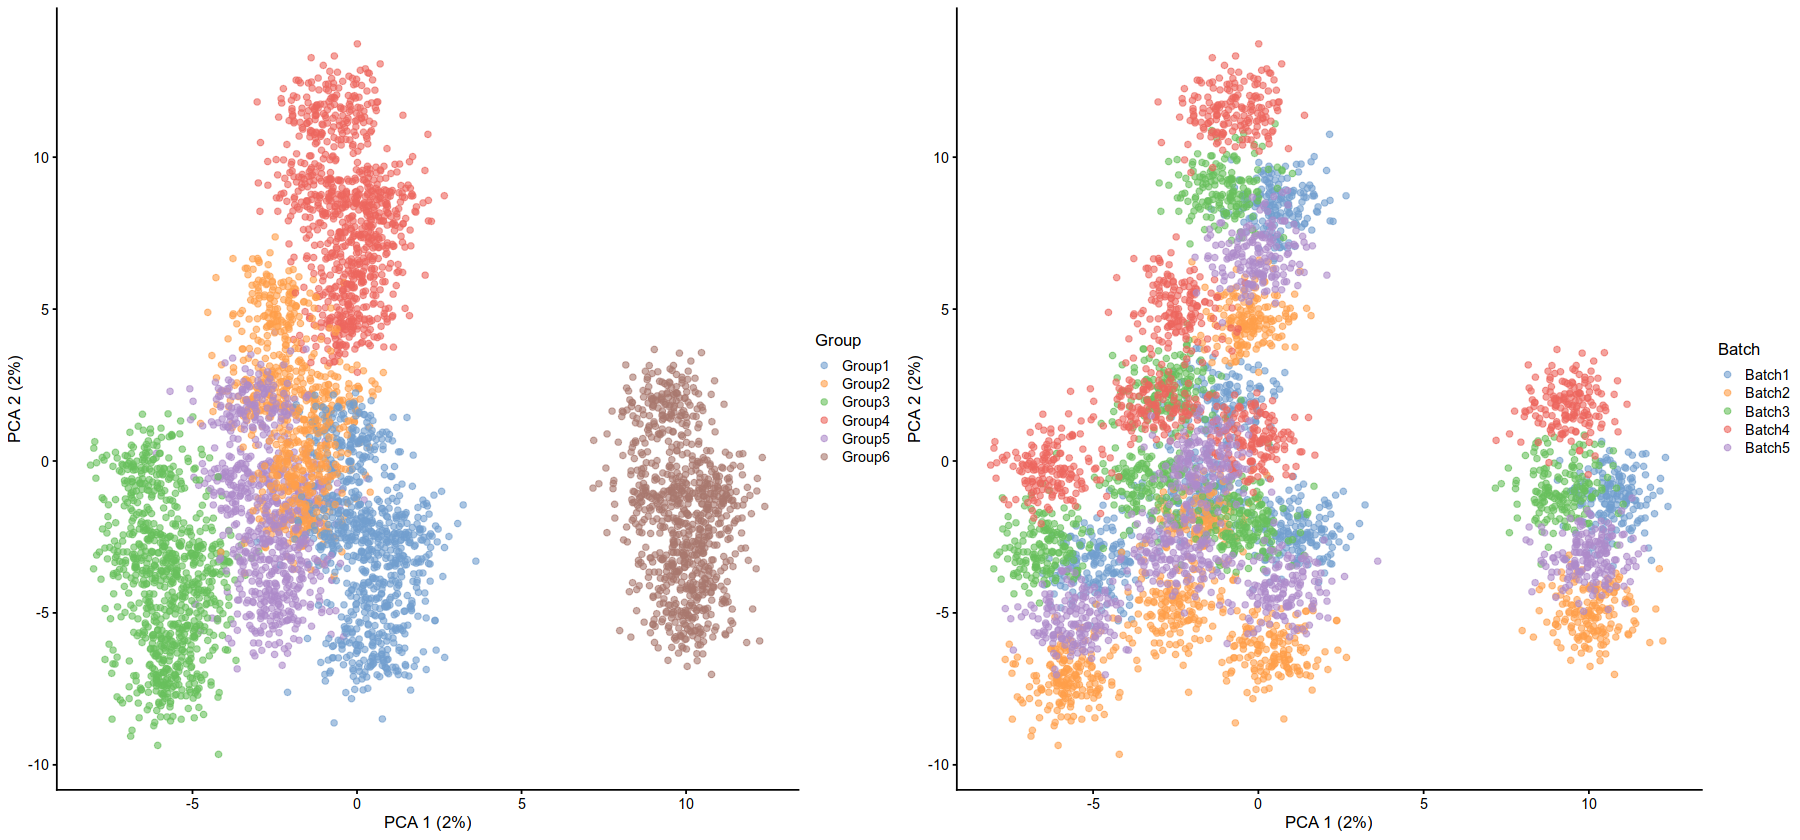

In [6]:
sim.gold.viz<-sim.gold

sim.gold.viz <- scater::logNormCounts(sim.gold.viz)
sim.gold.viz <- scran::fixedPCA(sim.gold.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(sim.gold.viz, colour_by = "Group")
g1b<-plotPCA(sim.gold.viz, colour_by = "Batch")

g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'missing_vals_pca', ext), g1, 
                                             height = h_, width = w_)}
g1

Gold standard CCC tensor with no omitted cell types or LR pairs:

In [90]:
# generate a LR PPI on a subset of the genes
set.seed(seed)
lr.genes<-sort(as.character(sample(rownames(sim.gold), size = n.lrs, replace = FALSE)))
lr.ppi<-generate.lr.ppi(lr.genes)
interacting.lr.genes<-unique(c(lr.ppi$source_genesymbol, lr.ppi$target_genesymbol))

#####

# split by context -- needed for LR omission and scoring
sim.gold.list<-split.by.context(sim.gold) 

# log-normalize
sim.gold.list<-lapply(sim.gold.list, FUN = function(sce) {
    sce <- scater::logNormCounts(sce)
})

# calculate communication scores
scores.gold<-score.communication(sim.gold.list, lr.ppi)

tensor.gold.elements<-list()
for (score.type in names(scores.gold)){
    tensor.gold.elements[[score.type]]<-get.tensor.elements(scores.gold, score.type)
}

# build and decompose tensor
tensor.gold<-list()
for (score.type in names(scores.gold)){
    tensor.gold[[score.type]]<-liana_tensor_c2c(context_df_dict = scores.gold[[score.type]],
                                           score_col = 'score',
                                           ligand_col = 'ligand', 
                                           receptor_col = 'receptor', 
                                           how = 'outer',
                                           seed = 888, 
                                           upper_rank = 25, 
                                           init = 'svd', 
                                           conda_env = env.name,
                                           rank = NULL) # estimate the rank by setting to NULL
    print(paste0('The rank using ', score.type, ' is ', tensor.gold[[score.type]]$rank))
    
}

Loading `ccc_protocols` Conda Environment

Building the tensor...

Estimating ranks...

Decomposing the tensor...



[1] "The rank using natmi is 4"


Loading `ccc_protocols` Conda Environment

Building the tensor...

Estimating ranks...

Decomposing the tensor...



[1] "The rank using sca is 6"


Visualize:

New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [1, 2, 3, 4, 5].”
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
• `Factor 5` -> `Factor.5`
• `Factor 6` -> `Factor.6`
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [1, 2, 3, 4, 5].”
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4` -> `Factor.4`
• `Factor 5` -> `Factor.5`
• `Factor 6` -> `Factor.6`
New names:
• `Factor 1` -> `Factor.1`
• `Factor 2` -> `Factor.2`
• `Factor 3` -> `Factor.3`
• `Factor 4

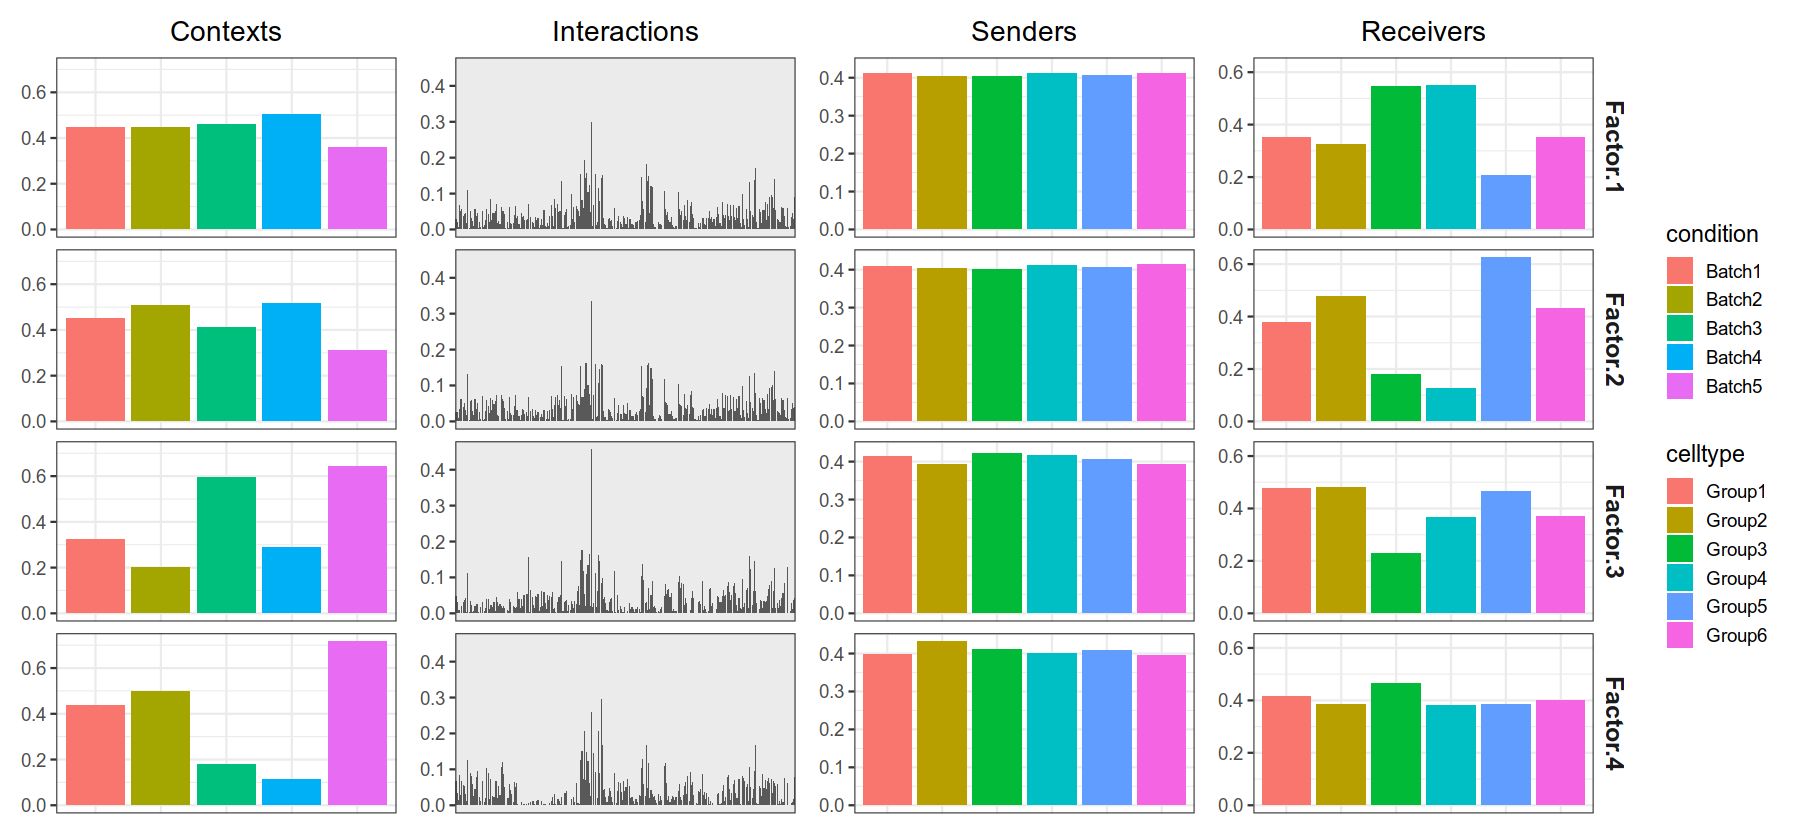

In [95]:
natmi.factors <- format_c2c_factors(tensor.gold$natmi$factors)
sca.factors <- format_c2c_factors(tensor.gold$sca$factors)

# Plot overview
plot_c2c_overview(natmi.factors)

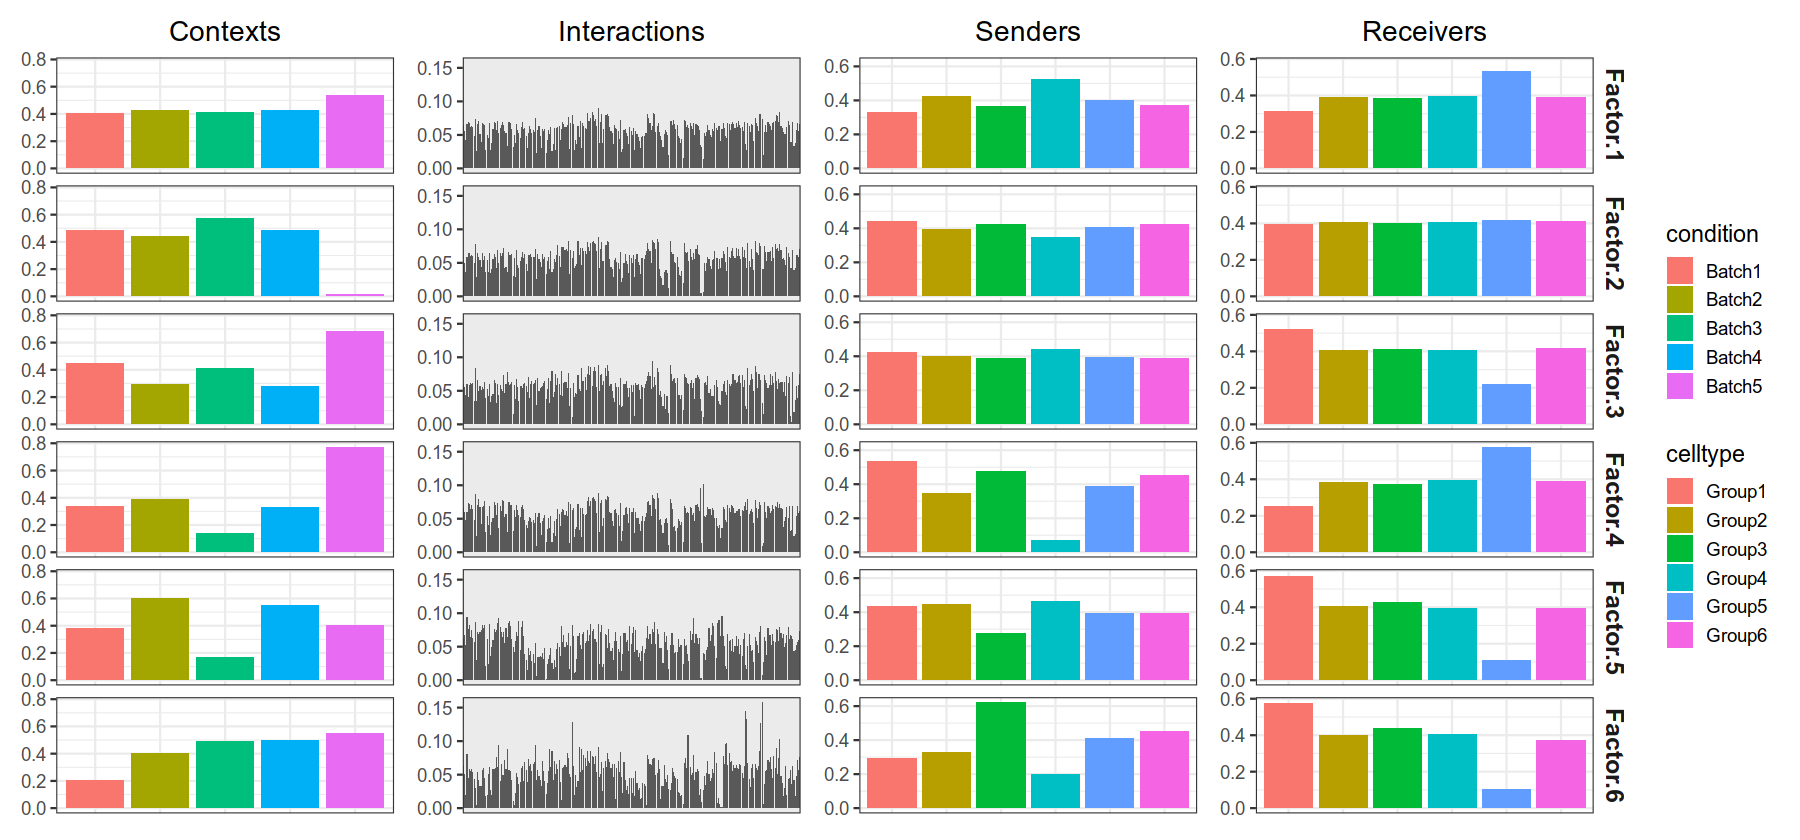

In [96]:
plot_c2c_overview(sca.factors)

## Set up Iterable Parameters

In [156]:
# fraction of .* to omit
frac.contexts = seq(0.2, 0.6, 0.2) # fraction of contexts to omit cell types
frac.cts = seq(1/6, 2/3, 1/6)
frac.lrs = seq(0.1, 0.6, 0.2)

# same or different .* to omit across contexts -- true/same is more difficult problem
consistent.remove.cts = c(TRUE, FALSE) 
consistent.remove.lrs = c(TRUE, FALSE)

The fraction and actual number of cell types to be ommitted is:

In [157]:
frac.contexts
frac.contexts*n.batches

[1] 0.2 0.4 0.6

[1] 1 2 3

The fraction and actual number of cell types to be ommitted is:

In [158]:
frac.cts
frac.cts*n.cell.types

[1] 0.1666667 0.3333333 0.5000000 0.6666667

[1] 1 2 3 4

The fraction and actual number of LRs to be ommitted is:

In [159]:
frac.lrs
frac.lrs*length(interacting.lr.genes)

[1] 0.1 0.3 0.5

[1] 13 39 65

In [205]:
iter.params.list<-list()
counter<-1
for (frac.ct in frac.cts){
    for (frac.lr in frac.lrs){
        for (frac.context in frac.contexts){
            for (cr.ct in consistent.remove.cts){
                for (cr.lr in consistent.remove.lrs){
                    iter.params.list[[counter]]<-list(frac.ct = frac.ct, frac.lr = frac.lr, 
                                                      frac.context = frac.context, cr.ct = cr.ct, cr.lr = cr.lr)
                    counter<-counter + 1
                }
            }
        }
    }
}

## Iterate

In [163]:
print(paste0('The number of iterations is: ', length(iter.params.list)))

[1] "The number of iterations is: 144"


In [256]:
res.df <- data.frame(matrix(ncol = 9, nrow = 0))
res.col.names<-c('iteration', 'celltype.fraction', 'lr.fraction', 'context.fraction', 'celltype.consistent', 'lr.consistent', 
                   'missing.fraction', 'corrindex.natmi', 'corrindex.sca')
colnames(res.df)<-res.col.names

seed.iter<-1
iter<-1

In [252]:
print('Begin iteration: ')
for (iter.params in iter.params.list){
    try({

        print(paste0('Iteration no.: ', iter))
        # select contexts, cell types, and LRs to omit-------------------------------------------------------------
        omit.contexts.ct <- random.omit(sim = sim.gold, md.group.label = 'Batch', frac = iter.params$frac.context, seed = seed.iter)
        seed.iter<-seed.iter + 1
        omit.contexts.lr <- random.omit(sim = sim.gold, md.group.label = 'Batch', frac = iter.params$frac.context, seed = seed.iter)
        seed.iter<-seed.iter + 1

        omit.cts <- list()
        if (iter.params$cr.ct){
            ocs <- random.omit(sim = sim.gold, md.group.label = 'Group', frac = iter.params$frac.ct, seed = seed.iter)
            seed.iter<-seed.iter + 1
            for (oc in omit.contexts.ct){
                omit.cts[[oc]] = ocs
            }
        }else{
            for (oc in omit.contexts.ct){
                omit.cts[[oc]] = random.omit(sim = sim.gold, md.group.label = 'Group', frac = iter.params$frac.ct, seed = seed.iter)
                seed.iter<-seed.iter + 1
            }
        }

        omit.lrs <- list()
        if (iter.params$cr.lr){
            set.seed(seed.iter)
            olrs<-sort(as.character(sample(interacting.lr.genes, size = iter.params$frac.lr*length(interacting.lr.genes), replace = FALSE)))
            seed.iter<-seed.iter + 1
            for (oc in omit.contexts.lr){
                omit.lrs[[oc]] = olrs
            }
        }else{
            for (oc in omit.contexts.lr){
                set.seed(seed.iter)
                olrs<-as.character(sample(interacting.lr.genes, size = iter.params$frac.lr*length(interacting.lr.genes), replace = FALSE))
                omit.lrs[[oc]] = olrs
                seed.iter<-seed.iter + 1
            }
        }
        # ----------------------------------------------------------------------------------------------------------
        set.seed(seed) # reset to main

        # apply the omissions
        sim.omit.list<-sim.gold.list

        for (context in names(omit.cts)){
            sce.omit <- sim.omit.list[[context]]
            cell.types.omit = omit.cts[[context]]
            barcodes.keep = rownames(colData(sce.omit)[!(colData(sce.omit)$Group %in% cell.types.omit),])
            sim.omit.list[[context]] <- sce.omit[, barcodes.keep]
        }


        for (context in names(omit.lrs)){
            sce.omit<-sim.omit.list[[context]]
            sim.omit.list[[context]]<-sce.omit[!(rownames(sce.omit) %in% omit.lrs[[context]]), ]
        }

        # get the communication scores------------------------------------------------------------------------------
        # only re-calculate scores on altered contexts to save computation time

        changed.contexts<-sort(unique(c(omit.contexts.ct, omit.contexts.lr)))
        scores.omit<-score.communication(sim.omit.list, lr.ppi, changed.contexts)

        scores.omit[['natmi']]<-c(scores.omit$natmi, 
                                          scores.gold$natmi[!(names(scores.gold$natmi) %in% changed.contexts)])
        scores.omit[['sca']]<-c(scores.omit$sca, 
                                          scores.gold$sca[!(names(scores.gold$sca) %in% changed.contexts)])
        scores.omit<-lapply(scores.omit, function(x) x[sort(names(x))])
        
                            
        # this will restore LR pairs that were completely removed during omitting process
        # happens bc they are not present in all contexts, so if removed in some contexts, may completely dissapear
        # making tensor dimensions different and corrindex calulation impossible
        # improve: should directly insert into tensor; right now using hacky way where adding the missing LRs
        # to any of the sample communication matrices will automatically add it to the constructed tensor
        tensor.omit.elements<-list()
        for (score.type in names(scores.omit)){
            tensor.omit.elements[[score.type]]<-get.tensor.elements(scores.omit, score.type)
        }

        for (score.type in names(scores.omit)){
            for (element.type in names(tensor.omit.elements[[score.type]])){
                elements.gold<-tensor.gold.elements[[score.type]][[element.type]]
                elements.omit<-tensor.omit.elements[[score.type]][[element.type]]
                if (length(elements.omit) < length(elements.gold)){
                    if (element.type != 'LRs'){stop('Need to account for non-LR missing elements')}
                    elements.missing<-setdiff(elements.gold, elements.omit)
                    # inserting missing LRs with a NaN score should make the tensor dimensions consistent
                    for(em in elements.missing){
                        context.score<-scores.omit[[score.type]][[1]]
                        to.add<-context.score[1, ]
                        to.add[['score']]<-NaN
                        lr.missing<-stringr::str_split(em, pattern='&')[[1]]
                        to.add[['ligand']]<-lr.missing[[1]]
                        to.add[['receptor']]<-lr.missing[[2]]
                        scores.omit[[score.type]][[1]]<-rbind(context.score, to.add)

                    }
                }
            }
        }                    
                            
        # build and decompose tensor
        tensor.omit<-list()
        for (score.type in names(scores.omit)){
            suppressMessages({
                suppressWarnings({
                        tensor.omit[[score.type]]<-liana_tensor_c2c(context_df_dict = scores.omit[[score.type]],
                                               score_col = 'score',
                                               ligand_col = 'ligand', 
                                               receptor_col = 'receptor', 
                                               how = 'outer',
                                               seed = 888, 
                                               init = 'svd', 
                                               conda_env = env.name,
                                               rank = tensor.gold[[score.type]]$rank) # same rank as gold-standard
                })
            })
        }

        # get the fraction of missing values
        # 1) excluded_value_fraction includes 0s and NaNs, so must subtract gold standard with no NaNs
        # 2) liana_tc2c fills missing values with 0 regardless of cell_fill and lr_fill argument, so would need to subtract anyways
    #     no.nans<-length(which((tensor.omit[[score.type]]$tensor == 0))) - length(which((tensor.gold[[score.type]]$tensor == 0)))
    #     frac.missing<-no.nans/length(tensor.omit[[score.type]]$tensor)
        frac.missing<-lapply(names(tensor.omit), 
                            function(score.type) tensor.omit[[score.type]]$excluded_value_fraction() 
                             - tensor.gold[[score.type]]$excluded_value_fraction())
        if (length(unique(frac.missing)) != 1){stop('Unexpected difference between score type missing indices')}  

        frac.missing<-unique(frac.missing)[[1]]

        # calculate corrindex
        corr.index<-list()
        for (score.type in names(tensor.gold)){
            corr.index[[score.type]]<- (1 - (c2c$tensor$metrics$correlation_index(tensor.gold[[score.type]]$factors, 
                                                                                tensor.omit[[score.type]]$factors)))
        }

        res<-c(iter, unname(unlist(iter.params)), frac.missing, corr.index$natmi, corr.index$sca)
        names(res)<-res.col.names
        res.df<-rbind(res.df, t(as.data.frame(res)))

        write.csv(res.df, paste0(data.path, 'interim/', 'missing_vals_benchmark.csv'))
    })
    iter<-iter + 1
}

[1] "Begin iteration: "
[1] "Iteration no.: 1"


Loading `ccc_protocols` Conda Environment

Building the tensor...

Decomposing the tensor...

Loading `ccc_protocols` Conda Environment

Building the tensor...

Decomposing the tensor...



[1] "/data3/hratch/ccc_protocols/interim/missing_vals_benchmark.csv"

# Analyse

## Visualize

In [286]:
res.df<-read.csv(paste0(data.path, 'interim/', 'missing_vals_benchmark.csv'))
res.df<-res.df[colnames(res.df) != 'X']

In [287]:
viz.df<-res.df
colnames(viz.df)<-c(colnames(viz.df)[1:(dim(viz.df)[[2]]-2)], 'natmi', 'sca')

viz.df<-melt(viz.df, id=colnames(viz.df)[!colnames(viz.df) %in% c('natmi', 'sca')], 
    value.name = 'corrindex', variable.name = 'score.type')

viz.df[['celltype.consistent']]<-as.factor(viz.df$celltype.consistent)
viz.df[['lr.consistent']]<-as.factor(viz.df$celltype.consistent)

head(viz.df)

,iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,score.type,corrindex
,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,1,0.1666667,0.1,0.2,1,1,0.12531080,natmi,0.9922528
2,2,0.1666667,0.1,0.2,1,1,0.10437063,natmi,0.9949525
3,3,0.1666667,0.1,0.2,0,0,0.09108392,natmi,0.9976709
4,4,0.1666667,0.1,0.2,0,0,0.08356643,natmi,0.9929904
5,5,0.1666667,0.1,0.4,1,1,0.15957653,natmi,0.9835308
6,6,0.1666667,0.1,0.4,1,1,0.18673271,natmi,0.9789397


Does the fraction of missing indices effect the CorrIndex?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



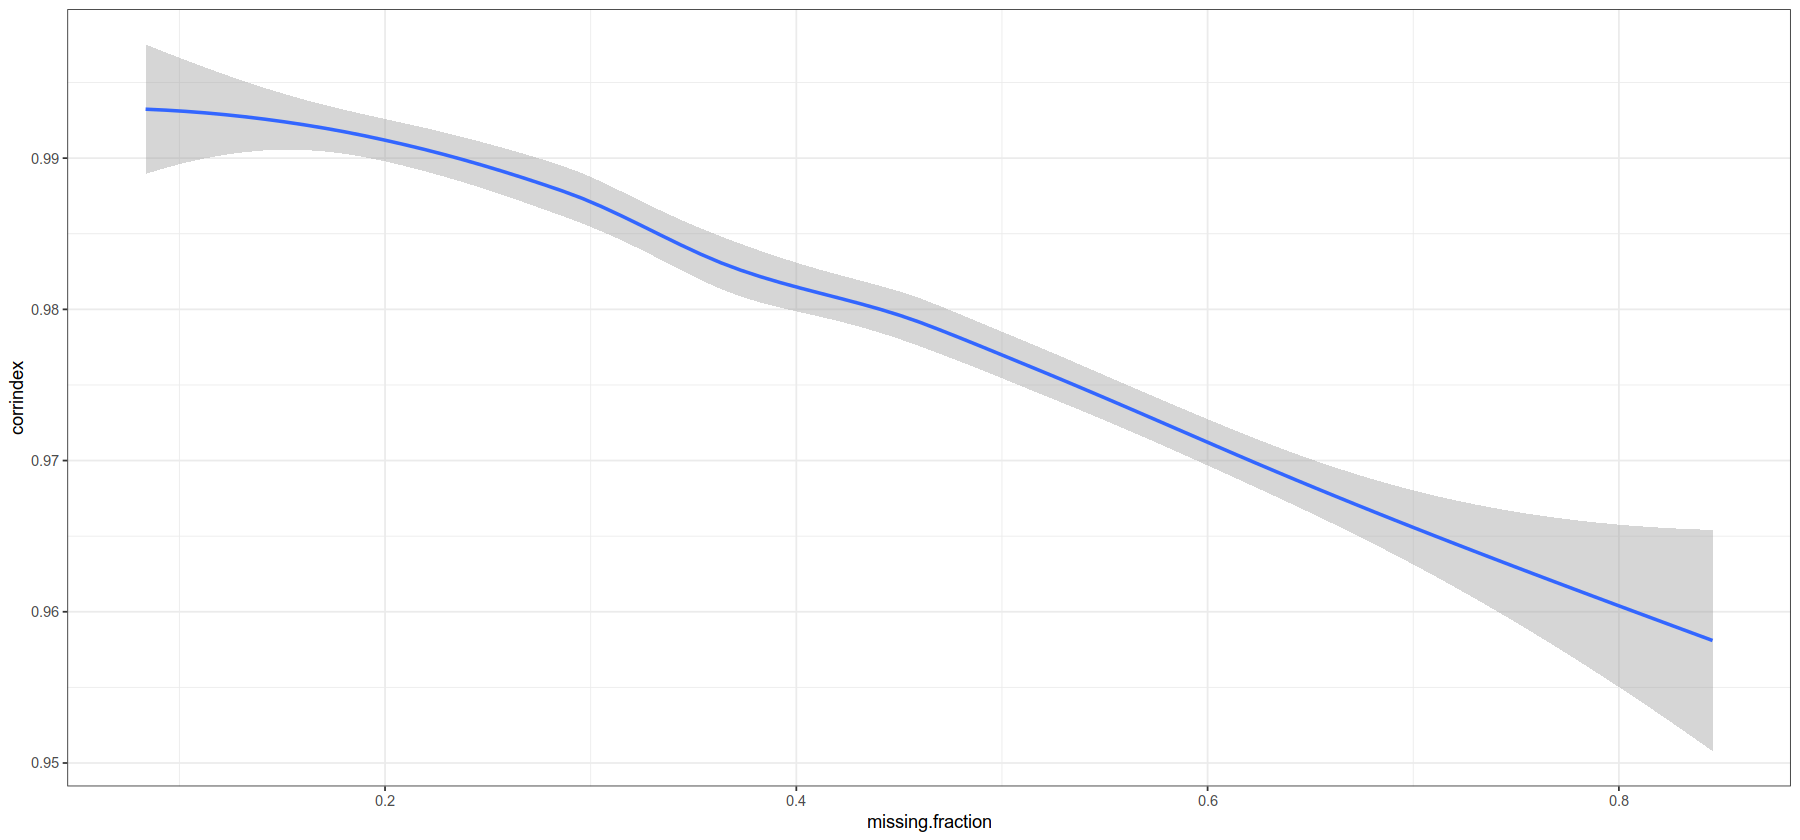

In [236]:
g1<-ggplot(viz.df, aes(x=missing.fraction, y=corrindex)) +
  geom_smooth() + theme_bw()
g1

Conclusion: While the fraction of missing indices clearly has an effect on CorrIndex (likely statistically significant), the effect size is pretty negligible 

Do either the score type or whether the same element is removed change the effect of the missing fraction on the CorrIndex?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



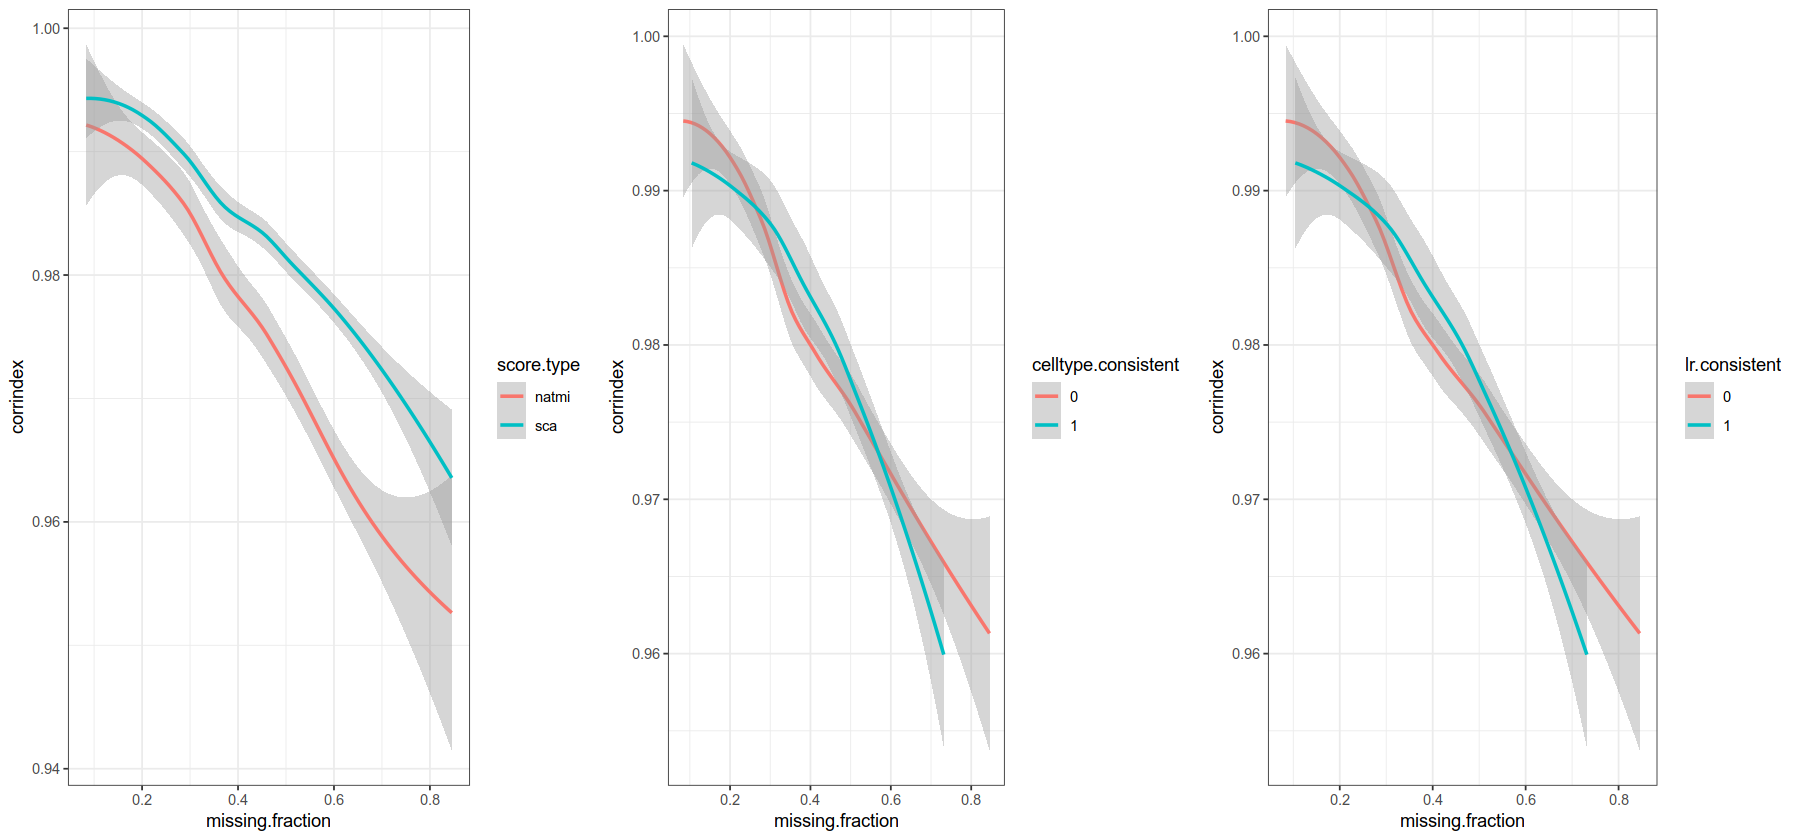

In [245]:
g2a<-ggplot(viz.df, aes(x=missing.fraction, y=corrindex, color = score.type)) +
  geom_smooth() + theme_bw()
g2b<-ggplot(viz.df, aes(x=missing.fraction, y=corrindex, color = celltype.consistent)) +
  geom_smooth() + theme_bw()
g2c<-ggplot(viz.df, aes(x=missing.fraction, y=corrindex, color = lr.consistent	)) +
  geom_smooth() + theme_bw()
g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3)
g2

* SCA consistnely outperforms NATMI across missing fractions, but there doesnt seem to be a strong effect of scoring method on (i.e., the slopes are the same b)
* Whether the same elements are removed across contexts or different ones doesn’t effect CorrIndex strongly for either the cell type or LR dimensions; at high and low missing fractions, removing the same elements seems to perform slightly worse (need statistical testing with binned violinplots), and vice versa at middle ranges of missing fraction


In [249]:
head(viz.df)

,iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,score.type,corrindex
,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,1,0.1666667,0.1,0.2,1,1,0.12531080,natmi,0.9922528
2,2,0.1666667,0.1,0.2,1,1,0.10437063,natmi,0.9949525
3,3,0.1666667,0.1,0.2,0,0,0.09108392,natmi,0.9976709
4,4,0.1666667,0.1,0.2,0,0,0.08356643,natmi,0.9929904
5,5,0.1666667,0.1,0.4,1,1,0.15957653,natmi,0.9835308
6,6,0.1666667,0.1,0.4,1,1,0.18673271,natmi,0.9789397


Do any of the specific elements going missing have a stronger influence on the CorrIndex (e.g., missing LRs vs missing contexts vs missing cell types)? 

In [306]:
# # have to add jitter for geome_smooth function, come back to this
# # https://stackoverflow.com/questions/38864458/loess-warnings-errors-related-to-span-in-r
# for (col in c('celltype.fraction', 'lr.fraction', 'context.fraction')){
#     viz.df[[col]] <- jitter(viz.df[[col]], factor = 0.05)
# }
for (col in c('celltype.fraction', 'lr.fraction', 'context.fraction')){
    viz.df[[col]] <- as.factor(viz.df[[col]])
}



In [327]:
unique(viz.df$context.fraction)

[1] 0.2 0.4 0.6
Levels: 0.2 0.4 0.6

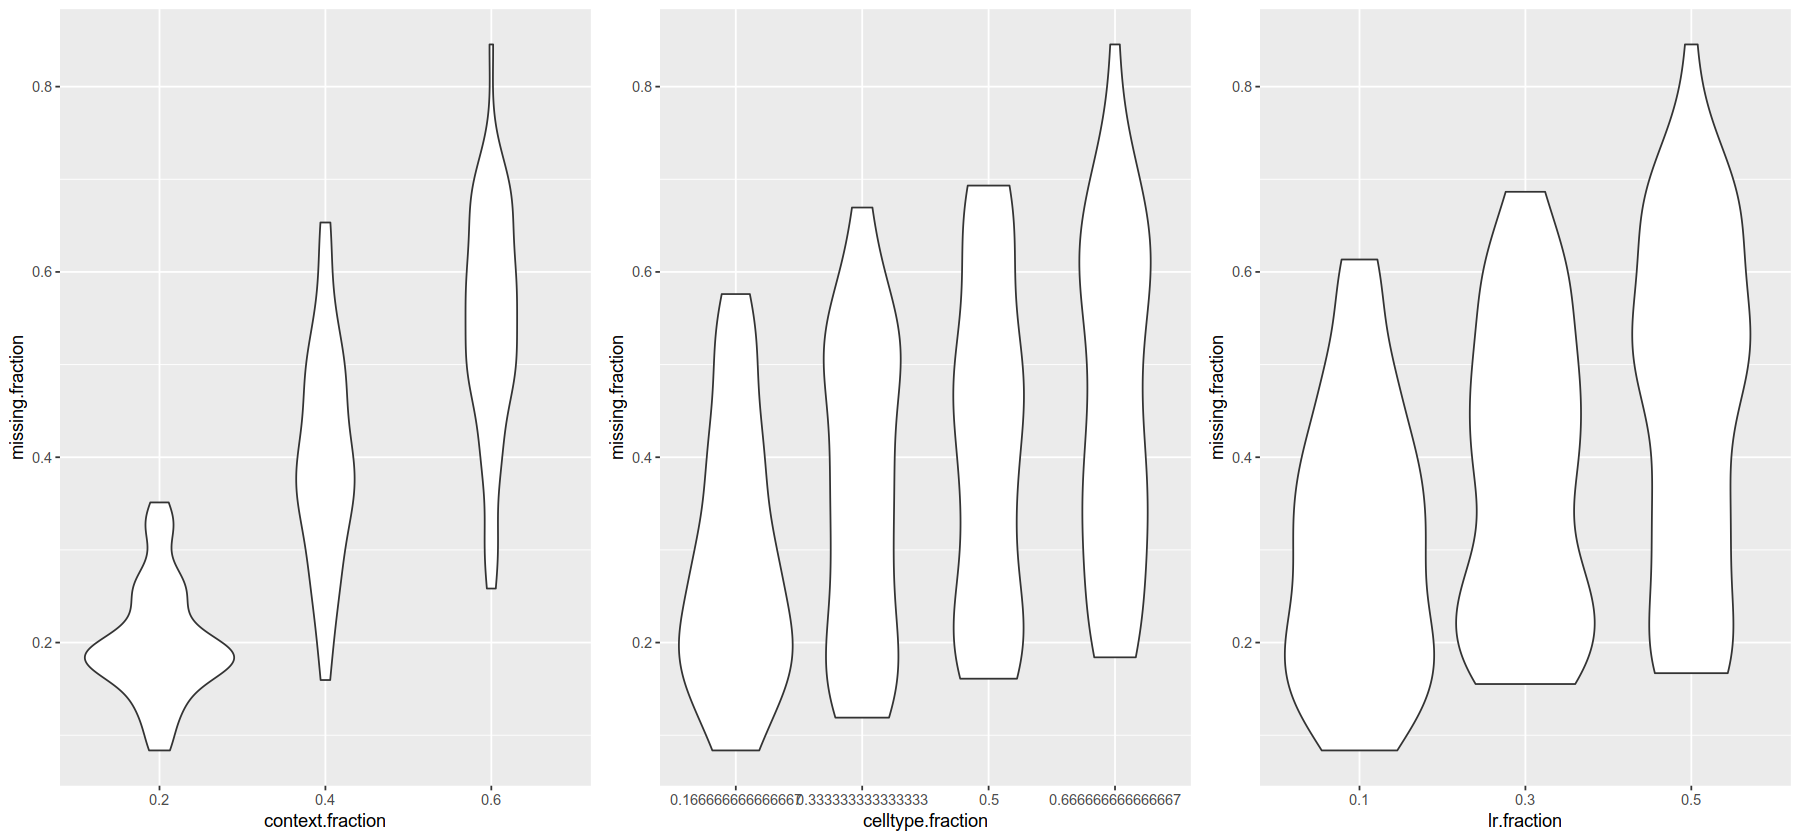

In [331]:
g3a<-ggplot(viz.df, aes(y=missing.fraction, x=context.fraction)) + geom_violin() 
g3b<-ggplot(viz.df, aes(y=missing.fraction, x=celltype.fraction)) + geom_violin() 
g3c<-ggplot(viz.df, aes(y=missing.fraction, x=lr.fraction)) + geom_violin() 

g3<-ggpubr::ggarrange(g3a, g3b, g3c, ncol = 3)
g3

First, we see that each has a similar relationship with the total missing fraction. 

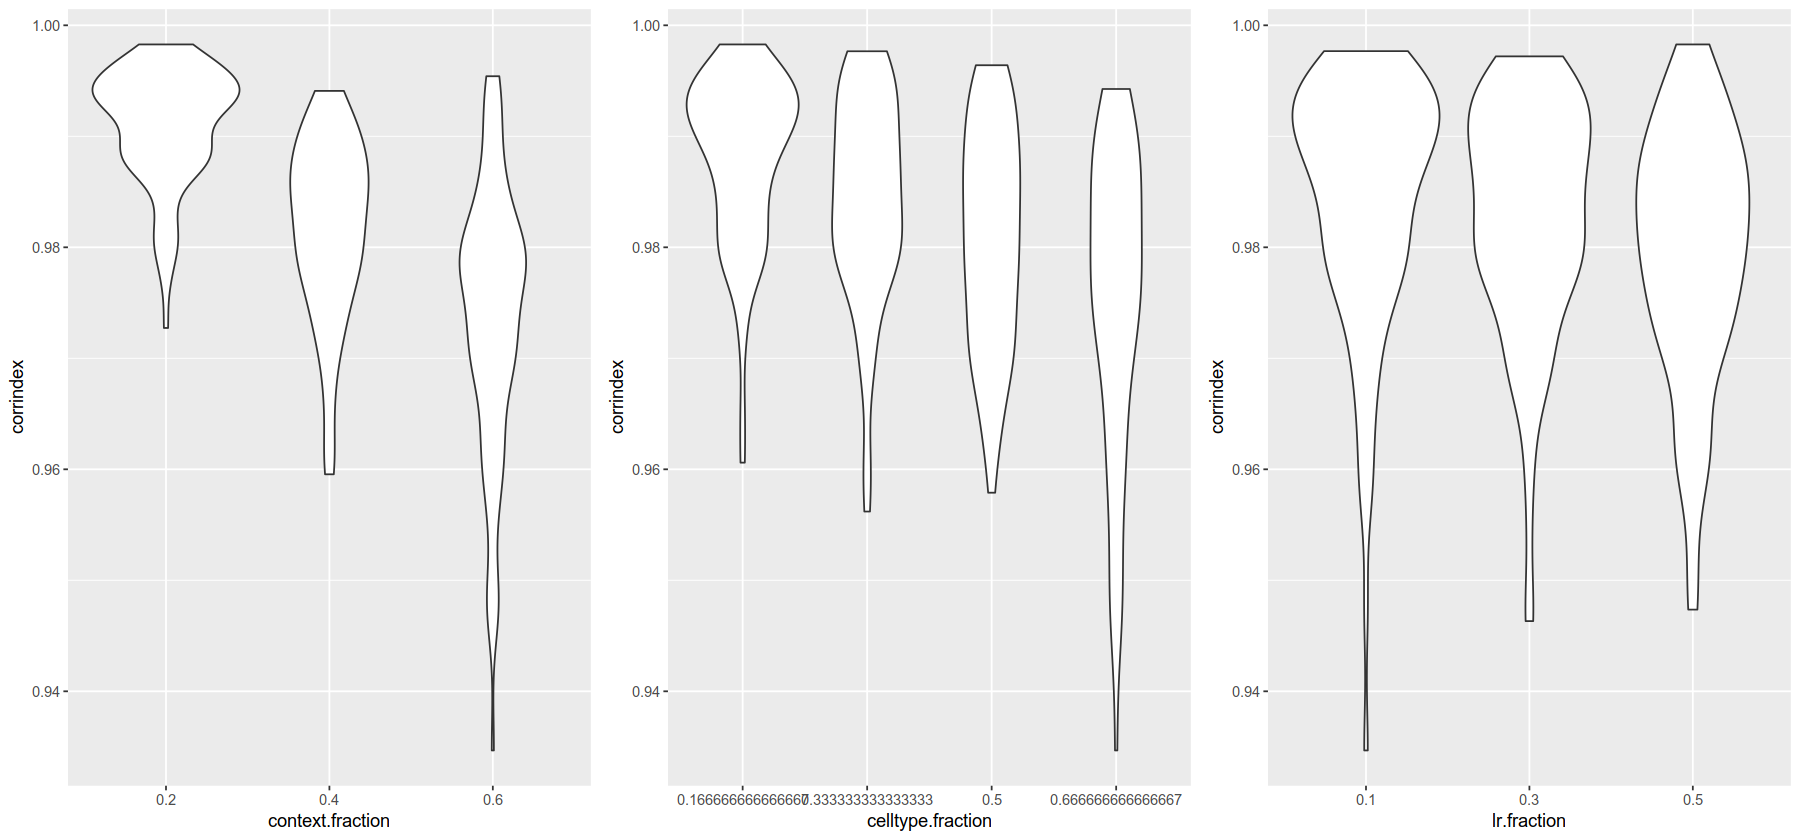

In [333]:
g4a<-ggplot(viz.df, aes(y=corrindex, x=context.fraction)) + geom_violin() 
g4b<-ggplot(viz.df, aes(y=corrindex, x=celltype.fraction)) + geom_violin() 
g4c<-ggplot(viz.df, aes(y=corrindex, x=lr.fraction)) + geom_violin() 

g4<-ggpubr::ggarrange(g4a, g4b, g4c, ncol = 3)
g4

In [277]:
viz.df[is.na(viz.df$context.fractio), ]

iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,score.type,corrindex
<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>


In [276]:
head(viz.df)

,iteration,celltype.fraction,lr.fraction,context.fraction,celltype.consistent,lr.consistent,missing.fraction,score.type,corrindex
,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,1,0.1666667,0.1,0.2,1,1,0.12531080,natmi,0.9922528
2,2,0.1666667,0.1,0.2,1,1,0.10437063,natmi,0.9949525
3,3,0.1666667,0.1,0.2,0,0,0.09108392,natmi,0.9976709
4,4,0.1666667,0.1,0.2,0,0,0.08356643,natmi,0.9929904
5,5,0.1666667,0.1,0.4,1,1,0.15957653,natmi,0.9835308
6,6,0.1666667,0.1,0.4,1,1,0.18673271,natmi,0.9789397
